In [34]:
import math
import random
import sys
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np 
from scipy import signal
from scipy import misc
import scipy
import cv2 as cv 
import itertools

In [35]:
#Global values for settings and ect
axis_font = {'fontname':'Arial', 'size':'16'}

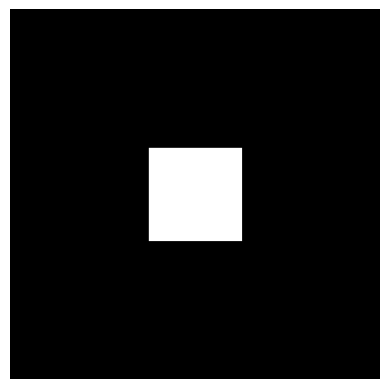

In [36]:


def square_in_square_image(N = 400, objectStart = 150, objectEnd = 250, B_Background = 0, B_Object = 255):
  """Create Image with solid background and in a center is square with chosen background intensity
     Image is garyscale
  """

  image = np.ones([N, N], dtype = np.uint8) * B_Background # create a new image with background color
  image[objectStart:objectEnd + 1, objectStart:objectEnd + 1] = B_Object
  return image

x = square_in_square_image()
plt.imshow(x, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

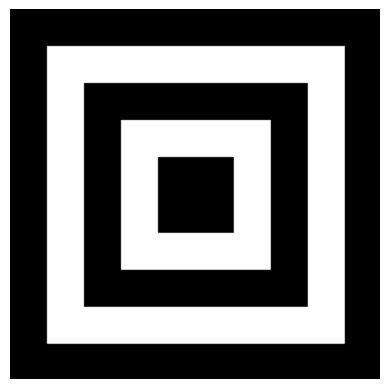

In [37]:
def NestedSquares(N = 200, Thickness = 20, B_Background = 0 , B_Object = 255, Squares = 5):

  image = np.ones([N,N], dtype = np.uint8) * B_Background
  color = B_Object

  for i in range(Squares-1):
    objectStart = Thickness * (i + 1)
    objectEnd = N - (Thickness * (i + 1))
    image[objectStart:objectEnd + 1, objectStart:objectEnd + 1] = color
    
    if color == B_Object:
      color = B_Background
    else:
      color = B_Object

  return image


y = NestedSquares()
plt.imshow(y, cmap='gray', vmin=0, vmax=255)  
plt.axis('off')
plt.show()

<h1 style="color:gold">Binary RLE</h1>

In [38]:
def rleEncode(data):
    encoding = ''
    prevChar = ''
    count = 1
    if not data: return ''
    for currChar in data:
        if currChar != prevChar:
            if prevChar:
                encoding += str(count) + prevChar
            count = 1
            prevChar = currChar
        else:
            count += 1
    else:
        encoding += str(count) + prevChar
        return encoding

In [39]:
def rleDecode(data):
    decode = ''
    count = ""
    for char in data:
        if char.isdigit():
            count += char
        else:
            decode += char * int(count)
            count = ""
    return decode

In [40]:

stringToEncode = random.randrange(20)*"A"+random.randrange(20)*"B"+random.randrange(20)*"C"+random.randrange(20)*"A"+random.randrange(20)*"L"
print("String to encode \n",stringToEncode)
encodedVal = rleEncode(stringToEncode)
print("Encoded String \n" ,encodedVal)
decodedVal = rleDecode(encodedVal)
print("String after decoding \n",decodedVal)

String to encode 
 AAAAAAAAAAAAACCCCCCCCAAAALLLL
Encoded String 
 13A8C4A4L
String after decoding 
 AAAAAAAAAAAAACCCCCCCCAAAALLLL


<h1 style="color:gold">RLE encode / decode binary image</h1>

In [41]:
# RLE encode / decode binary image

def rleEncodeImage(image, delimiter = ',', fileName = 'rle_encoded_binary_image.csv', pathToFile = 'content'):
  """
  Encode given image to csv file . fileName need to be csv file !

  The function returns a number - average bits per pixel that not include delimeter 
  """
  
  # pre processing - encode the image into a 1D ndarray of lengths, including height and width  
  flattenedImage = (image / 255).astype('uint8').flatten() 
  arrayOfLengths = np.empty([0], dtype = 'uint16') 
  valueToEncode = 0 
  COUNTER = 10000000 

  while (COUNTER > 0):
    if ((1 - valueToEncode) in flattenedImage):
      length = np.argmax(flattenedImage == (1 - valueToEncode)) 
      arrayOfLengths = np.append(arrayOfLengths, length)
      flattenedImage = flattenedImage[length:]
    else: 
      arrayOfLengths = np.append(arrayOfLengths, flattenedImage.shape[0])
      break
    COUNTER -= 1
    valueToEncode = 1 - valueToEncode 


  # generate header

  encodingType = 10 
  width = image.shape[1]
  height = image.shape[0]
  headerLenght = 4 

  # save header and arrayOfLengths to a file
  with open(pathToFile + '\\' + fileName, 'w') as f: 
    f.write('{0:d}'.format(headerLenght) + delimiter)
    f.write('{0:d}'.format(encodingType) + delimiter)
    f.write('{0:d}'.format(width) + delimiter)
    f.write('{0:d}'.format(height) + delimiter)
    for index in range(0, arrayOfLengths.shape[0] - 1): 
      f.write('{0:d}'.format(arrayOfLengths[index]) + delimiter)
    f.write('{0:d}'.format(arrayOfLengths[arrayOfLengths.shape[0] - 1])) 

  # calculate bits per pixel
  total_bits = 16 * (headerLenght + len(arrayOfLengths))
  bits_per_pixel = total_bits / (width * height)
  return bits_per_pixel


def rleDecodeImage(delimiter = ',', fileName = 'rle_encoded_binary_image.csv', pathToFile = 'content'):
  """
  Decode binary image from csv file.
  NOTE it has to be csv file !!!
  """
  
  with open(pathToFile + '\\' + fileName, 'r') as f: 
    for line in f: 
      listOfValues = line.split(delimiter)
      headerLenght = int(listOfValues[0], base = 10)
      encodingType = int(listOfValues[1], base = 10) # for binary RLE value is 10
      assert encodingType == 10, "rleDecodeImage() encountered encodingType != 10 not binary RLE"

      width = int(listOfValues[2], base = 10)
      height = int(listOfValues[3], base = 10)
      arrayOfLengths = np.empty([0], dtype = 'uint16') 
      for index in range(headerLenght, len(listOfValues)): 
        arrayOfLengths = np.append(arrayOfLengths, int(listOfValues[index], base = 10))

    imgFlat = np.empty([height * width], dtype = 'uint8')
    value = 0 
    location = 0
    for length in arrayOfLengths:
      imgFlat[location: location + length] = value 
      value = 255 - value 
      location = location + length 

    
    img = np.reshape(imgFlat, (-1, width)) 
    return img


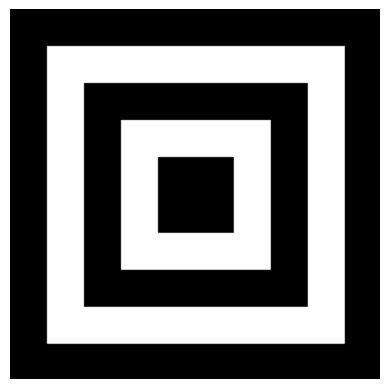

bits per pixel = 0.3252
original num bits assuming binary image = 40000
compression ratio = 3.075030750307503


In [42]:
nestedSqueres = NestedSquares() 
bpp = rleEncodeImage(nestedSqueres) 
decoded = rleDecodeImage() 
plt.imshow(decoded, cmap = 'gray') 
plt.axis('off')
plt.show()
bitsInImages = nestedSqueres.shape[0] * nestedSqueres.shape[1]
print(f"bits per pixel = {bpp}")
print(f"original num bits assuming binary image = {bitsInImages}")
print(f"compression ratio = {1/bpp}")


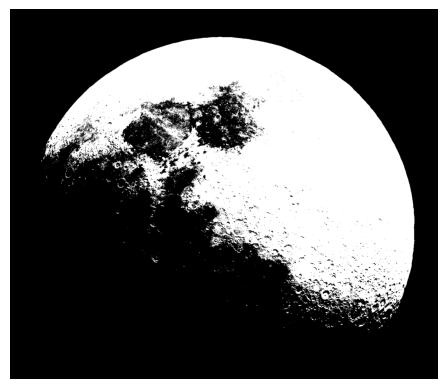

bits per pixel = 0.39947063688999174
original num bits assuming binary image = 1692600
compression ratio = 2.5033129037601456


In [43]:
# encode / decode sample image
sampleImage = 'Images/moon.png'
imgGrayscale = cv.imread(sampleImage, cv.IMREAD_GRAYSCALE) 
imgBinary = ((imgGrayscale > 80) * 255).astype('uint8')
fileName="moon_binary_image2.csv"

bpp = rleEncodeImage(imgBinary,fileName=fileName) 
decoded = rleDecodeImage(fileName=fileName) 
plt.imshow(decoded, cmap = 'gray') 
plt.axis('off')
plt.show()
bitsInImage = imgBinary.shape[0] * imgBinary.shape[1]
print(f"bits per pixel = {bpp}")
print(f"original num bits assuming binary image = {bitsInImage}")
print(f"compression ratio = {1/bpp}")

<h1 style="color:gold">Entropy</h1>

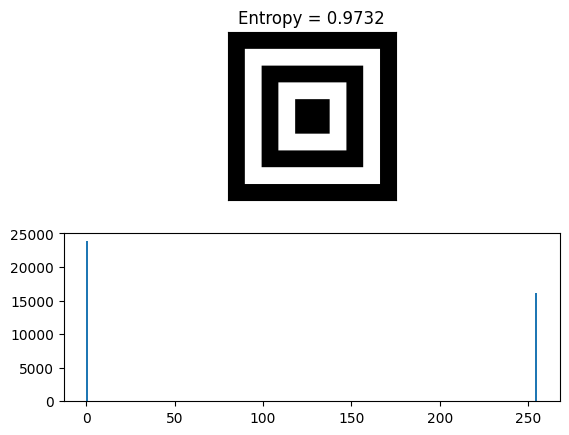

In [44]:
def EntropyOfImage(image):
  """
  calculate entropy of grayscale image and plot image and its histogram
  input :  image -- uint8 .
  """

  fig, axis = plt.subplots(2)
  histogram = plt.hist(image.flatten(), bins = 255)
  normalized_hist = histogram[0] / (image.shape[0] * image.shape[1])
  entropy = np.zeros(normalized_hist.shape) 
  for index in range(0, normalized_hist.shape[0]): 
    if (normalized_hist[index] != 0): 
      entropy[index] = normalized_hist[index]* np.log2(normalized_hist[index]) 
  entropy = -np.sum(entropy) 
  axis[0].imshow(image, cmap = 'gray')
  axis[0].set(title = 'Entropy = ' + '{0:0.4f}'.format(entropy))
  axis[0].get_xaxis().set_visible(False)
  axis[0].get_yaxis().set_visible(False)




image = NestedSquares()
EntropyOfImage(image)


plt.show()

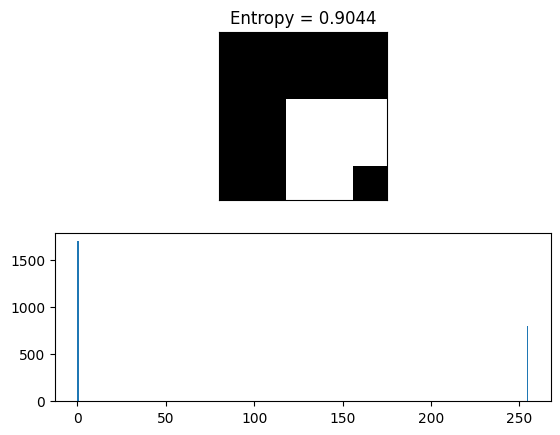

In [45]:
EntropyOfImage(image[:50,:50])
plt.show()

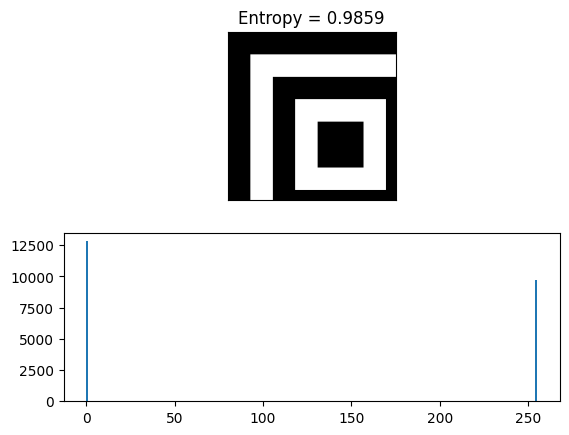

In [46]:
EntropyOfImage(image[:150,:150])
plt.show()

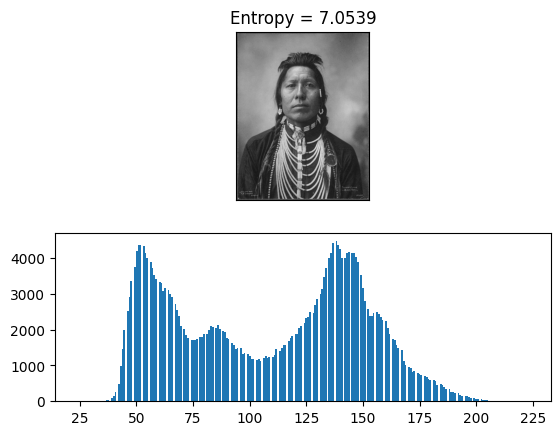

In [47]:
imagePath1= 'Images/indian.jfif' 
imageGrayscale1 = cv.imread(imagePath1, cv.IMREAD_GRAYSCALE) 
EntropyOfImage(imageGrayscale1)
plt.show()

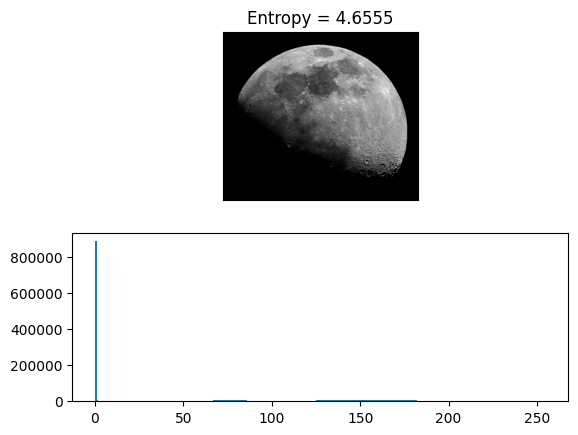

In [48]:
imagePath2 = 'Images/moon.png' 
imageGrayscale2 = cv.imread(imagePath2, cv.IMREAD_GRAYSCALE) 
EntropyOfImage(imageGrayscale2)
plt.show()

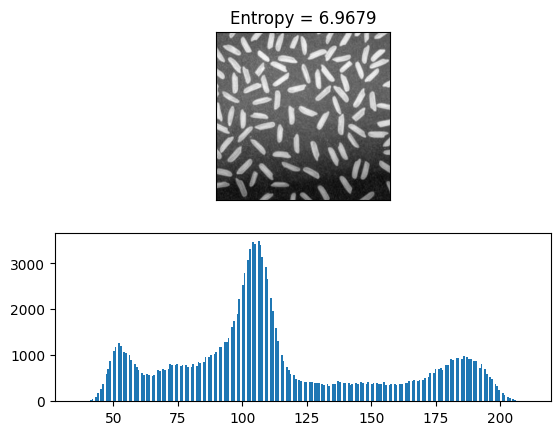

In [49]:
imagePath3 = 'Images/rice.tif' 
imageGrayscale3 = cv.imread(imagePath3, cv.IMREAD_GRAYSCALE) 
EntropyOfImage(imageGrayscale3)
plt.show()

In [50]:
# comparison with entropy method from internet
def entropy(labels):
  value,counts = np.unique(labels, return_counts=True)
  norm_counts = counts / counts.sum()
  return -(norm_counts * np.log2(norm_counts)).sum()

#---------------Calculation------------------------------
nestedEntropy = entropy(image.flatten())
neastedEntropy2 = entropy(image[:50,:50].flatten())
neastedEntropy3 = entropy(image[:150,:150].flatten())
indeanEntropy = entropy(imageGrayscale1.flatten())
moonEntropy = entropy(imageGrayscale2.flatten())
riceEntropy = entropy((imageGrayscale3 * 255).astype('uint8').flatten())
#---------------Printing---------------------------------
print(f"nested entropy = {nestedEntropy}")
print(f"nested[:50,:50] entropy = {neastedEntropy2}")
print(f"nested[:150,:150] entropy = {neastedEntropy3}" )
print(f"Indian entropy = {indeanEntropy}" )
print(f"Moon entropy = {moonEntropy}" )
print(f"rice entropy = {riceEntropy}")

nested entropy = 0.9732424074349136
nested[:50,:50] entropy = 0.9043814577244937
nested[:150,:150] entropy = 0.985905253016829
Indian entropy = 7.053905377831745
Moon entropy = 4.655580619263099
rice entropy = 6.967929968811961


<h1 style="color:gold"> DCT</h1>

In [51]:
def MSE_SNR_PSNR(SignalA, SignalB):
    """
        Signal B is Signal A with noise.
        Returning values order same as a name 
    """
    mse = (np.square(SignalA - SignalB)).mean()
    error_ = (SignalA - SignalB)
    sig_mean = (np.square(SignalA)).mean()
    noise_mean = (np.square(error_)).mean()
    snr = 10*np.log10(sig_mean/noise_mean)
    psnr = 20*np.log10(255) - mse 

    return mse, snr, psnr

True


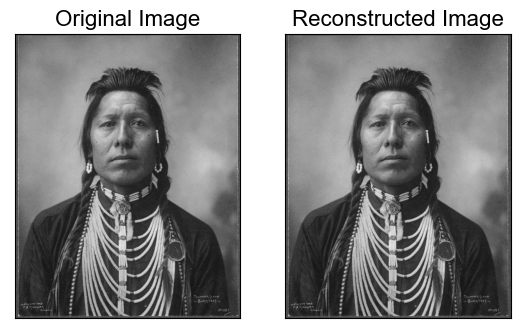

In [52]:
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')
    
def idct2(a):
    return idct(idct(a.T, norm='ortho').T, norm='ortho')




image = cv.imread("Images/indian.jfif",cv.IMREAD_GRAYSCALE) 

imageDCT = dct2(image)
imageIDCT = idct2(imageDCT)

print(np.allclose(image, imageIDCT))

fig , axis = plt.subplots(1,2)
axis[0].imshow(image,cmap="gray")
axis[0].set_title('Original Image', **axis_font)
axis[1].imshow(imageIDCT,cmap="gray")
axis[1].set_title('Reconstructed Image', **axis_font)

for ax in axis :
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


In [53]:
print(np.size(image))
print(np.size(imageIDCT))

323973
323973


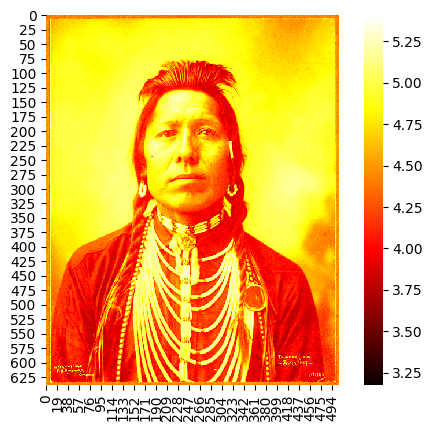

In [54]:
ax = sns.heatmap(np.log(np.abs(imageIDCT)),cmap = 'hot',square = True)
plt.show()

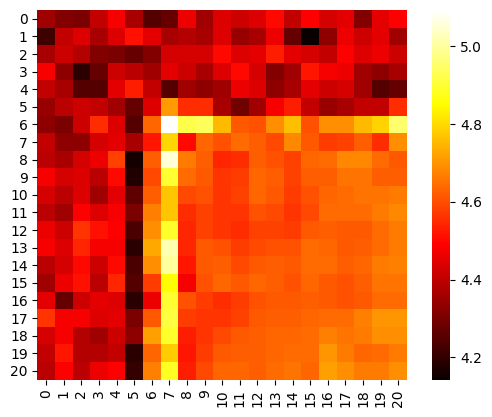

In [55]:
ax = sns.heatmap(np.log(np.abs(imageIDCT[0:21,0:21])),cmap = 'hot',square = True)
plt.show()

In [56]:
img = cv.imread("Images/indian.jfif",cv.IMREAD_GRAYSCALE).astype(np.uint8)
f = plt.figure()
plt.imshow(img[:,:],cmap='gray')

img = img[:,:]

In [57]:
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

In [69]:
imsize = img.shape
dct = np.zeros(imsize)

for i in np.r_[:imsize[0]:8]:
    for j in np.r_[:imsize[1]:8]:
        dct[i:(i+8),j:(j+8)] = dct2(img[i:(i+8),j:(j+8)] )

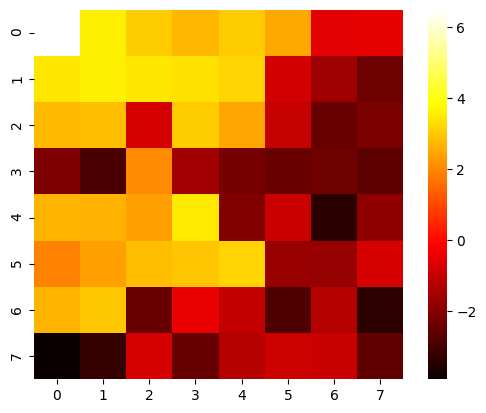

In [70]:
ax = sns.heatmap(np.log(np.abs(dct[0:8,0:8])),cmap = 'hot',square = True)
plt.show()

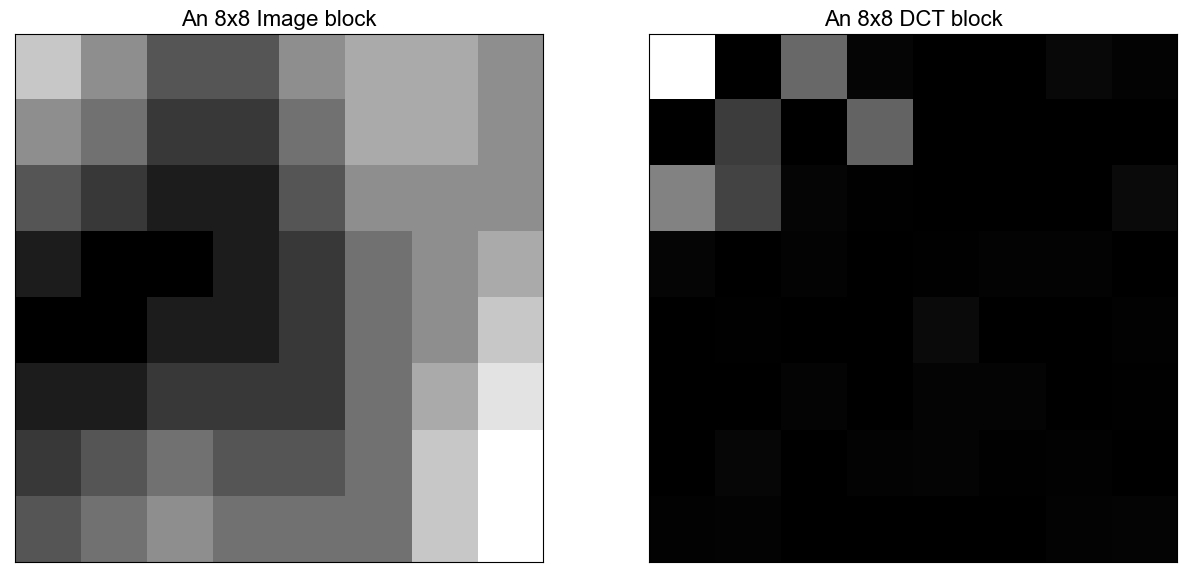

In [77]:
pos = 128
plots = []
plots.append(img[pos:pos+8,pos:pos+8])
plots.append(dct[pos:pos+8,pos:pos+8])
titles = ["An 8x8 Image block","An 8x8 DCT block"]
fig , axis =  plt.subplots(1,2,figsize=[15,8]) 

for image , title, ax ,flag in itertools.zip_longest(plots,titles,axis,range(0,2)):
    if not flag :
        ax.imshow(image,cmap='gray')
    else:
        ax.imshow(image,cmap='gray',vmax= np.max(dct)*0.01,vmin = 0, extent=[0,np.pi,np.pi,0])
    ax.set_title(title,**axis_font)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


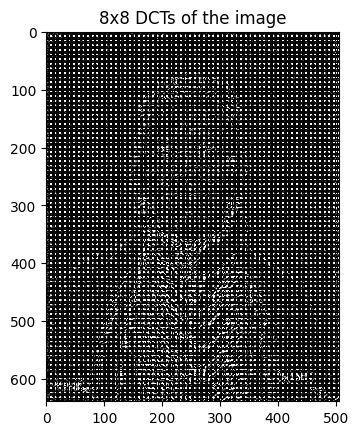

In [72]:

plt.figure()
plt.imshow(dct,cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
plt.title( "8x8 DCTs of the image")
plt.show()

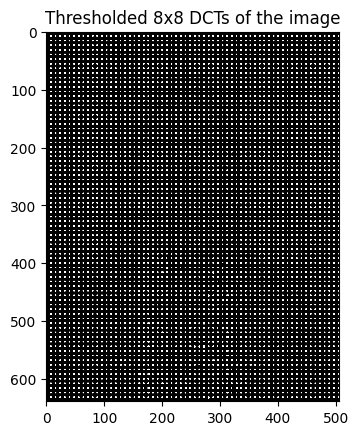

Keeping only 1.633778% of the DCT coefficients


In [62]:

thresh = 0.17
dctThresh = dct * (abs(dct) > (thresh*np.max(dct)))


plt.figure()
plt.imshow(dctThresh,cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
plt.title( "Thresholded 8x8 DCTs of the image")
plt.show()


percentNonzeros = np.sum( dctThresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
print ("Keeping only %f%% of the DCT coefficients" % (percentNonzeros*100.0))

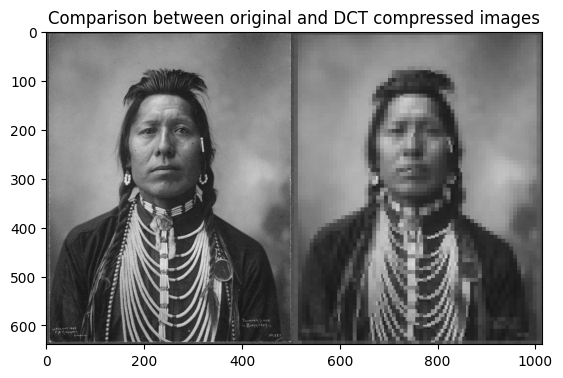

In [63]:
im_dct = np.zeros(imsize)

for i in np.r_[:imsize[0]:8]:
    for j in np.r_[:imsize[1]:8]:
        im_dct[i:(i+8),j:(j+8)] = idct2( dctThresh[i:(i+8),j:(j+8)] )
        
        
plt.figure()
plt.imshow( np.hstack( (img, im_dct) ).astype(np.uint8) ,cmap='gray')
plt.title("Comparison between original and DCT compressed images" )
plt.show()